In [76]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
import time
from tqdm import tqdm_notebook as tqdm
from AutoRegression import AutoRegression
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [210]:
def smape(satellite_predicted_values, satellite_true_values): 
    # the division, addition and subtraction are pointwise 
    return np.mean(np.abs((satellite_predicted_values - satellite_true_values) 
        / (np.abs(satellite_predicted_values) + np.abs(satellite_true_values))))


def delete_duplicates(df, eps=10):
    """
        Returns df without "duplicates" - objects within each sat_id,
        which were recorded at almost same time
    """
    
    for sat_id in df['sat_id'].unique():
        d_t = df[df['sat_id'] == sat_id].epoch.apply(lambda x: time.mktime(datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%f').timetuple())).values
        df = df.drop(index=df[df['sat_id'] == sat_id].index[0] + np.where((np.roll(d_t, -1)[:-1] - d_t[:-1]) < eps)[0])
    return df

In [211]:


PATH_TO_DATA = os.path.join('/Documents/Project Lambda/IDAO 2020/Track 1')
full_train = pd.read_csv('train.csv', index_col='id')
full_test = pd.read_csv('test.csv', index_col='id')

## delete duplicates from train and test
full_train = delete_duplicates(full_train)
full_test_wout_dup = delete_duplicates(full_test.copy())

# Initial autoreg model

In [222]:
width_list = [60, 48,  72]  ## widths of window, which will be used for prediction
coefs_for_ensemble = [0.2, 0.2, 0.6] ## coefs for ensemblin models


# predict for test dataset without duplicates:
target_columns = ['x', 'y', 'z', 'Vx', 'Vy', 'Vz']
for col in target_columns:
    full_test_wout_dup[col] = 0.0

for sat_id in tqdm(full_test_wout_dup.sat_id.unique()):
    for width, coef in zip(width_list, coefs_for_ensemble):
        df = full_train[full_train.sat_id == sat_id]
        test_satid_mask = full_test_wout_dup.sat_id == sat_id
        for col in target_columns:
            model = AutoRegression(width=width)
            model.fit(df[col].values)
            full_test_wout_dup.loc[full_test_wout_dup[test_satid_mask].index, col] +=\
                coef * model.predict(len(full_test_wout_dup[test_satid_mask]))


## after this we need to predict for deleted objects (duplicates) from test,
 ## so we decided to fill predicts with values of nearest objects in time domain
final_df = pd.concat([full_test, full_test_wout_dup[target_columns]], axis=1)
final_df.fillna(method='ffill', inplace=True)

## saving predictions
final_df[target_columns].to_csv('submission2.csv', index_label='id')
## check to prevent submit errors
print(final_df[target_columns].isna().sum())


x     0
y     0
z     0
Vx    0
Vy    0
Vz    0
dtype: int64


In [224]:
test_ans = pd.read_csv('ans.csv')
pred = pd.read_csv('submission2.csv')

In [225]:
smape(test_ans, pred)

id    0.000000
x     0.060256
y     0.060607
z     0.064801
Vx    0.065084
Vy    0.064139
Vz    0.069026
dtype: float64

In [17]:
for column in target_columns:
    err = smape(final_df[column], test_ans[column])
    print(column + ' smape = ' + str(err))

x smape = 0.7418121486246797
y smape = 0.7612663714650593
z smape = 0.8096258466728112
Vx smape = 0.7266359764604824
Vy smape = 0.7535967148019831
Vz smape = 0.787531624218616


In [41]:
100 * (1 - np.mean(smape(test_ans, pred)))

94.51553404889076

# Some ARIMA experiments

In [43]:
tr = pd.read_csv('train.csv', index_col='id')
sample = tr[tr.sat_id == 4]


In [48]:
import datetime
from pytz import timezone
import pytz

def epoch_to_ts(epoch):
    return datetime.datetime.strptime(epoch, '%Y-%m-%dT%H:%M:%S.%f').timestamp()

sample['timestamp'] = sample['epoch'].apply(epoch_to_ts)

In [176]:
diff = sample[['timestamp', 'x', 'x_sim']]
diff = diff.set_index('timestamp')
diff['x'] = diff.x - diff.x_sim
diff.drop('x_sim', axis=1, inplace=True)
diff

,x
timestamp,
1.388524e+09,65.548607
1.388526e+09,50.471610
1.388528e+09,29.632413
1.388530e+09,13.804985
1.388532e+09,5.763623
...,...
1.391192e+09,1601.752246
1.391194e+09,8287.837110
1.391196e+09,12851.205577


In [78]:
def get_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries['x'])
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

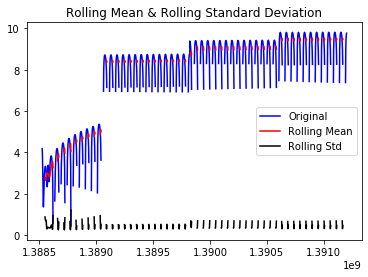

In [68]:
rolling_mean = diff.rolling(window = 12).mean()
rolling_std = diff.rolling(window = 12).std()
plt.plot(diff, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')

plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

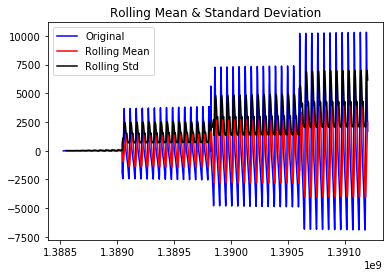

ADF Statistic: -11.271690519358204
p-value: 1.531273307989317e-20
Critical Values:
	1%: -3.435880398285223
	5%: -2.8639821109786747
	10%: -2.5680702282397765


In [85]:
diff_log = np.log(diff)

diff_log_shift = diff_log - diff_log.shift()
diff_log_shift.dropna(inplace=True)

diff_shift = diff - diff.shift()
diff_shift.dropna(inplace=True)

get_stationarity(diff_shift)

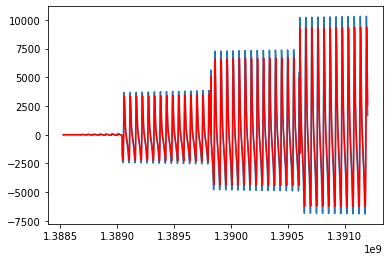

In [192]:
decomposition = seasonal_decompose(diff, period=20) 
model = ARIMA(diff, order=(1,1,0))
results = model.fit(disp=-1, trend='nc')
plt.plot(diff_shift)
plt.plot(results.fittedvalues, color='red')

pred = results.predict(1, 1087)

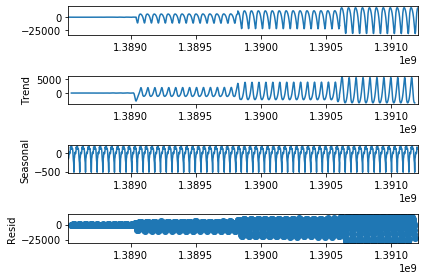

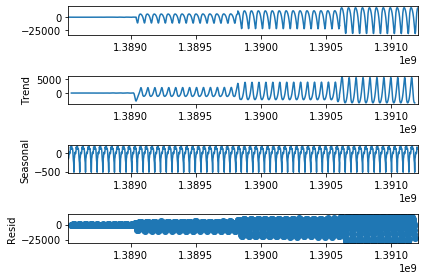

In [165]:
decomposition.plot()

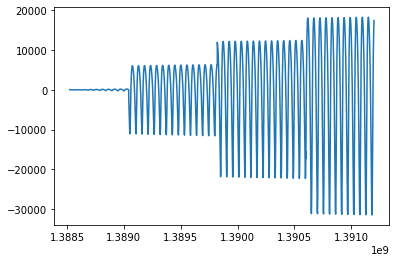

In [96]:
diff.plot()

In [99]:
full_train[full_train.sat_id == 4].epoch

id
7292    2014-01-01T00:00:00.000
7293    2014-01-01T00:36:59.800
7294    2014-01-01T01:13:59.600
7295    2014-01-01T01:50:59.401
7296    2014-01-01T02:27:59.201
                 ...           
8497    2014-01-31T21:09:59.870
8498    2014-01-31T21:46:59.670
8499    2014-01-31T22:23:59.471
8500    2014-01-31T23:00:59.271
8501    2014-01-31T23:37:59.071
Name: epoch, Length: 1207, dtype: object

In [193]:
targ = full_test[full_test.sat_id == 4].x_sim.values + pred.values

In [194]:
full_test[full_test.sat_id == 4]

,sat_id,epoch,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
id,,,,,,,,
8502,4,2014-02-01T00:14:58.871,-6324.807281,-21437.173777,-33246.022243,-2.587188,-0.326005,0.272131
8503,4,2014-02-01T00:51:58.672,-11944.575237,-21836.337046,-32146.964043,-2.464509,-0.034801,0.712347
8504,4,2014-02-01T01:28:58.472,-17216.008703,-21597.378751,-30108.023128,-2.274062,0.248982,1.119201
8505,4,2014-02-01T02:05:58.272,-21991.697408,-20736.577613,-27202.012080,-2.017883,0.525489,1.493562
8506,4,2014-02-01T02:42:58.072,-26124.375111,-19270.272313,-23501.808761,-1.694127,0.794439,1.834388
...,...,...,...,...,...,...,...,...
9584,4,2014-02-28T16:57:23.515,-17030.164484,-21834.040230,-30032.541822,-2.273957,0.222086,1.126685
9585,4,2014-02-28T17:34:23.315,-21808.105681,-21029.039520,-27110.824040,-2.020031,0.502229,1.500194
9586,4,2014-02-28T18:11:23.115,-25947.955110,-19609.547600,-23397.022392,-1.698446,0.775644,1.839967


This is approximation of score calculated for 1 satellite

In [195]:
smape(test_ans.iloc[8502:9589].x, targ)

0.6864109348954059

# ARIMA training  + predictions

In [217]:
width_list = [1]  ## widths of window, which will be used for prediction
coefs_for_ensemble = [1] ## coefs for ensemblin models


# predict for test dataset without duplicates:
target_columns = ['x', 'y', 'z', 'Vx', 'Vy', 'Vz']
#for col in target_columns:
#    full_test_wout_dup[col] = 0.0

for sat_id in tqdm(full_test_wout_dup.sat_id.unique()):
    for width, coef in zip(width_list, coefs_for_ensemble):
        df = full_train[full_train.sat_id == sat_id]
        test_satid_mask = full_test_wout_dup.sat_id == sat_id
        n = test_satid_mask.sum()
        for col in target_columns:
            diff = df[col] - df[col + '_sim']
            #print(diff.shape)
            model = ARIMA(diff, order=(1,1,0))
            results = model.fit(disp=-1, trend='nc')
            preds = results.predict(1, n).values
            #print(preds.isna().sum(), full_test_wout_dup.loc[full_test_wout_dup[test_satid_mask].index, col].isna().sum())
            full_test_wout_dup.loc[full_test_wout_dup[test_satid_mask].index, col] =\
                full_test_wout_dup.loc[full_test_wout_dup[test_satid_mask].index, col +'_sim'].values + preds


## after this we need to predict for deleted objects (duplicates) from test,
 ## so we decided to fill predicts with values of nearest objects in time domain
final_df = pd.concat([full_test, full_test_wout_dup[target_columns]], axis=1)
final_df.fillna(method='ffill', inplace=True)

## saving predictions
final_df[target_columns].to_csv('submission2.csv', index_label='id')
## check to prevent submit errors
print(final_df[target_columns].isna().sum())


x     0
y     0
z     0
Vx    0
Vy    0
Vz    0
dtype: int64


In [219]:
final_df

,sat_id,epoch,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim,x,y,z,Vx,Vy,Vz
id,,,,,,,,,,,,,,
3927,1,2014-02-01T00:01:45.162,-13366.891347,-14236.753503,6386.774555,4.333815,-0.692764,0.810774,-13366.891347,-14236.753503,6386.774555,4.333815,-0.692764,0.810774
3928,1,2014-02-01T00:22:57.007,-7370.434039,-14498.771520,7130.411325,5.077413,0.360609,0.313402,-7362.340388,-14497.654298,7126.538513,5.074439,0.363551,0.311696
3929,1,2014-02-01T00:44:08.852,-572.068654,-13065.289498,7033.794876,5.519106,2.012830,-0.539412,-571.853669,-13061.982099,7029.055403,5.516164,2.012170,-0.538785
3930,1,2014-02-01T01:05:20.697,6208.945257,-9076.852425,5548.296900,4.849212,4.338955,-1.869600,6205.341887,-9075.843732,5545.876345,4.848554,4.337913,-1.868543
3931,1,2014-02-01T01:26:32.542,10768.200284,-2199.706707,2272.014862,1.940505,6.192887,-3.167724,10764.413706,-2200.416676,2271.700723,1.940759,6.192396,-3.166986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1231060,597,2014-02-28T05:19:01.386,28595.031634,-85458.623976,5021.767767,-1.721131,-0.011611,0.122357,33049.761770,-86460.478399,4752.891416,-1.788925,-0.068587,0.132105
1231061,597,2014-02-28T07:21:46.454,15547.173728,-84233.509948,5840.616702,-1.815323,0.353445,0.098927,19454.789939,-85727.136011,5653.153734,-1.869845,0.311534,0.106474
1231062,597,2014-02-28T09:24:31.522,1981.107111,-80123.860051,6458.394351,-1.858963,0.773846,0.067379,5445.440130,-81996.969105,6335.796395,-1.903605,0.739724,0.073577


In [ ]:
test_ans = pd.read_csv('ans.csv')
pred = pd.read_csv('submission2.csv')

In [221]:
smape(test_ans, pred)

id    0.000000
x     0.338458
y     0.340736
z     0.348352
Vx    0.352464
Vy    0.359954
Vz    0.359915
dtype: float64

So we can conclude that in general ARIMA doesn't work :sad_face: